# Models based on the Dirichlet distribution and Dirichlet process

## Bayesian finite mixture model

The Bayesian finite mixture model has the following general generative story, followig Liang et al. (2007):

$(\beta_1,\dots,\beta_K) \sim \text{Dirichlet}(\alpha_1,\dots,\alpha_K)$

$\text{For each component } z\in \{1,\dots,K\}: \\
\qquad \phi_z \sim G_0$

$\text{For each datapoint } i \in \{1,\dots,n\}: \\
\qquad z_i \sim \text{Multinomial}(\beta_1,\dots,\beta_K) \\
\qquad x_i \sim F(\phi_{z_i})\\$

Below we give an example of a specific Bayesian finite mixture model taken from Marin et al. "Bayesian Modelling and Inference on Mixtures of Distributions" (2005). In this case:

$(\beta_1,\dots,\beta_K) = (1,\dots,1) $ and $F(\phi_z) = N(\mu_z, \sigma_z^2)$ 

where

$\mu_z \sim \text{Uniform}[0, 5\log K]$ 

and

$\sigma_z^2 \sim \text{Beta}(1/(0.5 + 0.1\log K), 1)$.



In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [69]:
from scipy.stats import gamma, norm
from math import log

def generate_mixture_pdf(K):
    """
    Mixture of K Gaussians with:
    K mixture weights from Dir(1,..,1)
    K means from Uniform[0, 5*log(K)]
    K variances from Beta(1/(0.5 + 0.1*log(K)), 1)
    :returns: a mixture pdf with the above paramaters
    """
    pi = np.random.dirichlet(K*[1])
    mu = np.random.uniform(low=0, high=5*log(K), size=K)
    var = np.random.beta(1/(0.5+0.1*log(K)), 1, size=K)
    return lambda x: sum([pi[i]*norm.pdf(x, loc=mu[i], scale=var[i]) for i in range(K)])

def plot_mixture(K):
    """
    Plot a density function generated by generate_mixture_pdf
    with K components
    """
    mixture_pdf = generate_mixture_pdf(K)
    
    # find the support of the mixture pdf:
    r_min = [x for x in range(10,-100,-1) if mixture_pdf(x)>0.0001][-1]
    r_max = [x for x in range(-10,100) if mixture_pdf(x)>0.0001][-1]
    
    xs = np.linspace(r_min, r_max, num=1000)
    plt.plot(xs, map(mixture_pdf, xs))
    plt.show()
    plt.clf()

def sample_mixture(K, sample_size):
    """
    Step wise sampling from a finite mixture model.
    The resulting histogram corresponds to the corresponding
    density function.
    """
    pi = np.random.dirichlet(K*[1])
    mu = np.random.uniform(low=0, high=5*log(K), size=K)
    var = np.random.beta(1/(0.5+0.1*log(K)), 1, size=K)
    
    # create the pdf
    mixture_pdf = lambda x: sum([pi[i]*norm.pdf(x, loc=mu[i], scale=var[i]) for i in range(K)])
    
    sample = []
    for i in range(sample_size):
        z = np.argmax(np.random.multinomial(1, pi))
        x = np.random.normal(loc=mu[z], scale=var[z])
        sample.append(x)
    return sample, mixture_pdf

We can generate mixture-pdf's for different values of K:

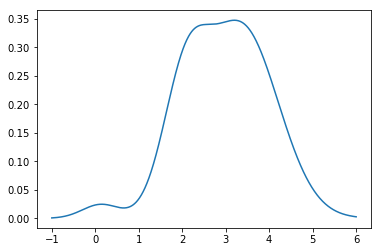

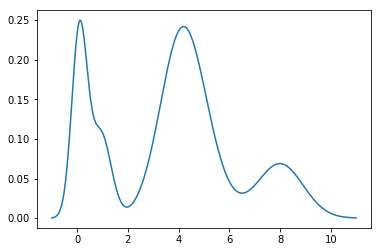

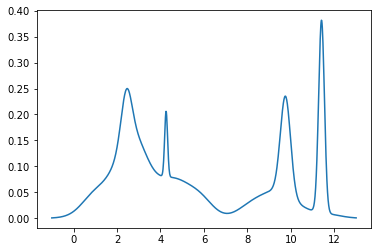

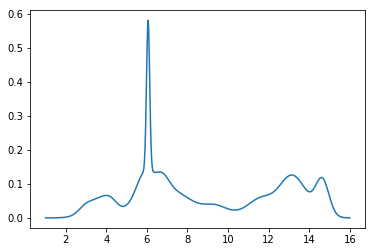

In [62]:
plot_mixture(3)
plot_mixture(5)
plot_mixture(15)
plot_mixture(25)

We can see that sampling stepwise (following the generative story) gives the same distribution as given by the pdf:

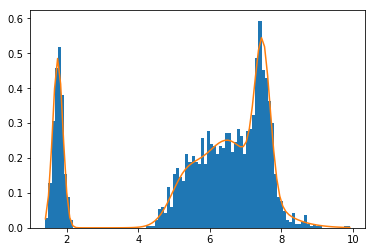

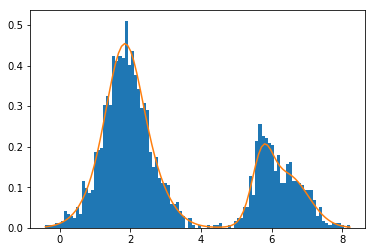

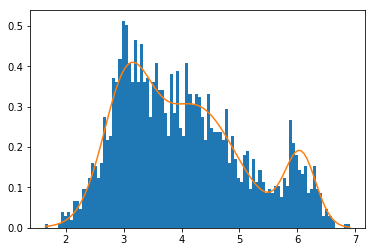

In [61]:
for i in range(3):
    sample, mixture_pdf = sample_mixture(5, sample_size=2000)

    fig, ax = plt.subplots()
    num_bins = 100
    n, bins, patches = ax.hist(sample, num_bins, normed=True)
    plt.plot(bins, [mixture_pdf(x) for x in bins])
    plt.show()
    plt.clf()

## Dirichlet process mixture model

Following Liang et al. (2007):

$\beta \sim \text{GEM}(\alpha)$

$\text{For each component } z\in \{1,2,\dots\}: \\
\qquad \phi_z \sim G_0$

$\text{For each datapoint } i \in \{1,\dots,n\}: \\
\qquad z_i \sim \text{Multinomial}(\beta) \\
\qquad x_i \sim F(\phi_{z_i})\\$

where we recall that the GEM$(\alpha)$ distribution is given by the stick-breaking process.

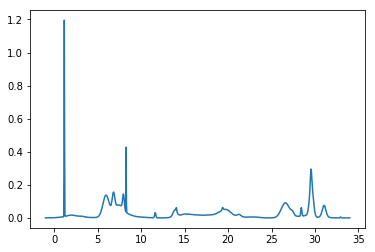

In [73]:
def stick_breaking(alpha=10, K=100):
    betas = np.random.beta(1, alpha, size=K)
    return [betas[i]*np.prod([1-betas[j] for j in range(i)]) for i in range(K)]

def generate_inf_mixture_pdf(K, alpha=10):
    betas = stick_breaking(alpha=alpha, K=K)
    mu = np.random.uniform(low=0, high=5*log(K), size=K)
    var = np.random.beta(1/(0.5+0.1*log(K)), 1, size=K)
    return lambda x: sum([betas[i]*norm.pdf(x, loc=mu[i], scale=var[i]) for i in range(K)])

def plot_inf_mixture(K, alpha=10):
    mixture_inf_pdf = generate_inf_mixture_pdf(K, alpha=10)
    
    # find the support of the mixture pdf:
    r_min = [x for x in range(10,-100,-1) if mixture_inf_pdf(x)>0.0001][-1]
    r_max = [x for x in range(-10,100) if mixture_inf_pdf(x)>0.0001][-1]
    
    xs = np.linspace(r_min, r_max, num=1000)
    plt.plot(xs, map(mixture_inf_pdf, xs))
    plt.show()
    plt.clf()
    
def sample_inf_mixture(K, sample_size):
    pi = np.random.dirichlet(K*[1])
    mu = np.random.uniform(low=0, high=5*log(K), size=K)
    var = np.random.beta(1/(0.5+0.1*log(K)), 1, size=K)
    mixture_pdf = lambda x: sum([pi[i]*norm.pdf(x, loc=mu[i], scale=var[i]) for i in range(K)])
    sample = []
    for i in range(sample_size):
        z = np.argmax(np.random.multinomial(1, pi))
        x = np.random.normal(loc=mu[z], scale=var[z])
        sample.append(x)
    return sample, mixture_pdf

# K = 25
plot_inf_mixture(1000, alpha=100)


## Gibbs sampling from a simple DP mixture

We consider the following simple DP mixture model taken from: Xiaodong Yu (2009) - Gibbs Sampling Methods for Dirichlet Process Mixture Model: Technical Details.

$$
G\sim\text{DP}(\alpha, N(0,10)) \\
\mu_i \sim G \\
x_i|\mu_i \sim N(\mu_i,1)
$$

The model thus has the following mixture pdf

$$
\sum_{i=1}^{\infty} \pi_i f(x|\mu_i,1)
$$

where $f(x|\mu_i,1)$ is the pdf of a $N(\mu_i,1)$ distribution, and $\pi_i, \mu_i$ come from the stick-breaking representation of $G$:

$$
\pi_i \sim \text{GEM}(\alpha) \\
\mu_i \sim N(0,1)\\
G = \sum_{i=1}^{\infty} \pi_i\delta_{\mu_i}.
$$



The DP mixture model:

In [2]:
import random

def sample_G(G):
    """
    :param G: a random distr drawn from a DP
    repr.: [(stick_location, stick_height)]
    """
    u = np.random.uniform(0,1)
    i = 0
    accum = 0.0
    while u > accum:
        accum += G[i][0] # add stick length
        i+=1
    return G[i]

def DP_mixture_pdf(K, alpha=10):
    
    # draw a G from DP(alpha, Normal(0,10))
    sticks = stick_breaking(alpha=alpha, size=K)
    locs = np.random.normal(0, 10, K)
    plt.vlines(locs, np.zeros(K), sticks, alpha=1)
    print "G:"
    plt.show()
    G = zip(sticks, locs)
    
    # sample from G
    samples = [sample_G(G) for i in range(K)]
    pis, mus = zip(*samples)
    print "Samples from G:"
    plt.vlines(mus, np.zeros(K), pis, alpha=1)
    plt.show()
    
    # return a mixture of N(0,1) distributions located
    # at the the samples from G
    pdf = lambda x: sum([pis[i]*norm.pdf(x, loc=mus[i], scale=1) for i in range(K)])
    
    return pdf, pis, mus

def plot_DP_mixture_pdf(K, pdf):
    
    # find the support of the mixture pdf:
    r_min = [x for x in range(10,-100,-1) if pdf(x)>0.0001][-1]
    r_max = [x for x in range(-10,100) if pdf(x)>0.0001][-1]
    
    # plot the mixture pdf
    xs = np.linspace(r_min, r_max, num=1000)
    plt.plot(xs, map(pdf, xs))
    plt.show()
    plt.clf()

def sample_DP_mixture(pis, mus, sample_size=100):
    samples = []
    for i in range(sample_size):
        mu = random.choice(mus)
        x = np.random.normal(loc=mu, scale=1)
        samples.append(x)
    return samples

def plot_samples(samples):
    num_bins = 50
    n, bins, patches = plt.hist(samples, num_bins, normed=True)
    plt.show()

G:


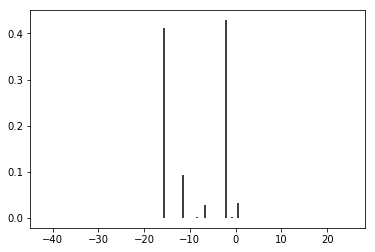

Samples from G:


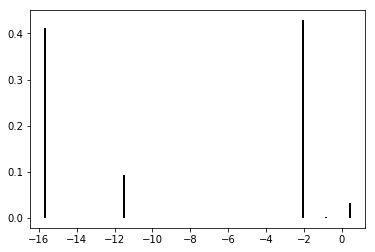

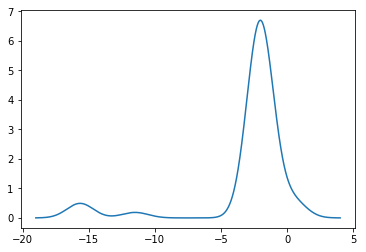

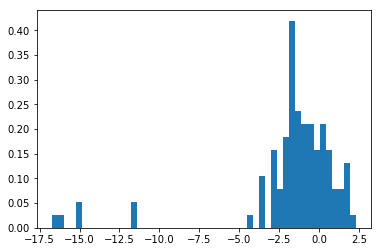

In [162]:
K = 100
alpha = 1

pdf, pis, mus = DP_mixture_pdf(K, alpha=alpha)

plot_DP_mixture_pdf(K, pdf)
samples = sample_DP_mixture(pis, mus)
plot_samples(samples)

G:


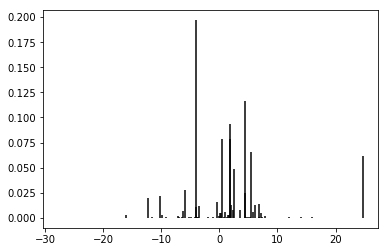

Samples from G:


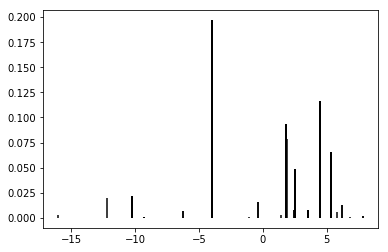

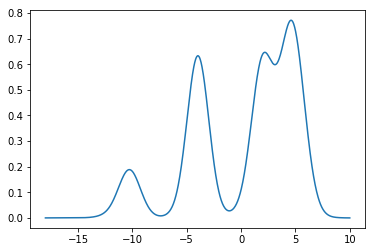

In [163]:
K = 100
alpha = 10

pdf, pis, mus = DP_mixture_pdf(K, alpha=alpha)
plot_DP_mixture_pdf(K, pdf)

G:


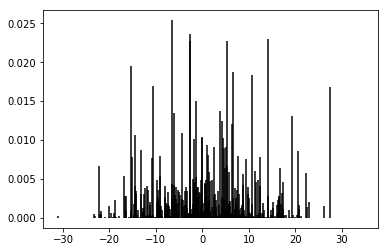

Samples from G:


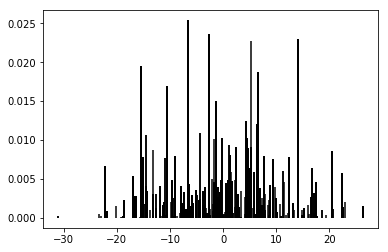

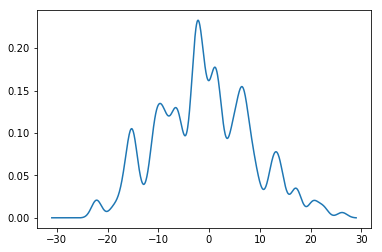

In [164]:
K = 1000
alpha = 100

pdf, pis, mus = DP_mixture_pdf(K, alpha=alpha)
plot_DP_mixture_pdf(K, pdf)

The Gibbs sampler: